# Uber Taxidaten in NYC mit Aufgabe
## Zeitraum April bis September 2014
- Rohdaten enthalten Datum mit Uhrzeit und den Länge/Breite, wohin ein Uber bestellt wurde
- jede Zeile repräsentiert eine Fahrt

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

%env SPARK_LOCAL_HOSTNAME=localhost
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import *

env: SPARK_LOCAL_HOSTNAME=localhost


In [2]:
# Daten einlesen mit typisiertem Schema
# Dateipfad *.csv bedeutet alle csv werden geladen
spark = SparkSession.builder.appName("TaxiData").getOrCreate()

schema = StructType([
    StructField("date", StringType()),
    StructField("lat", DoubleType()),
    StructField("lon", DoubleType()),
    StructField("base", StringType())
])

csv = spark.read.option("header", "true").csv("./data/uber/*.csv", schema = schema).cache()

In [3]:
csv.show()

+----------------+-------+--------+------+
|            date|    lat|     lon|  base|
+----------------+-------+--------+------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|
|8/1/2014 0:21:00|40.7399|-74.0057|B02512|
|8/1/2014 0:25:00|40.7651|-73.9683|B02512|
|8/1/2014 0:27:00|40.7354|-74.0081|B02512|
|8/1/2014 0:29:00|40.7339|-74.0028|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:30:00|40.7252|-73.9516|B02512|
|8/1/2014 0:30:00|40.7433| -73.986|B02512|
|8/1/2014 0:34:00|40.7437|-73.9884|B02512|
|8/1/2014 0:36:00|40.7406|-74.0077|B02512|
+----------

In [4]:
# erste Spalte als Datum noch auf String
# Ziel: echtes Datumsformat verwenden mittels eigener Funktion
csv.printSchema()

root
 |-- date: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



**`strptime(date_string, format)`**
- *`date_string`* ist der Sring, wie er in den Daten vorliegt
- *`format`* muss das vorliegende Format des *`date_strings`* wiedergeben

In [5]:
# importiere datetime KLasse
from datetime import datetime
# Benutzerdefinierte Funktion (User defined function)
from pyspark.sql.functions import udf

# mit dieser Funktion lässt sich die Datumsspalte umwandeln
f = udf(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"), TimestampType())

**`udf` kann nun in der `withColumn()`-Funktion als zweiter Parameter zum Umwandeln in Datumsformat genutzt werden**

In [6]:
csv.withColumn("date", f(csv.date)).printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



PySpark SQL - Dokumentation: http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html

In [7]:
# Fertige Formatierung der Daten
###
data = csv.withColumn("date", f(csv.date))
data.show()

+-------------------+-------+--------+------+
|               date|    lat|     lon|  base|
+-------------------+-------+--------+------+
|2014-08-01 00:03:00|40.7366|-73.9906|B02512|
|2014-08-01 00:09:00| 40.726|-73.9918|B02512|
|2014-08-01 00:12:00|40.7209|-74.0507|B02512|
|2014-08-01 00:12:00|40.7387|-73.9856|B02512|
|2014-08-01 00:12:00|40.7323|-74.0077|B02512|
|2014-08-01 00:13:00|40.7349|-74.0033|B02512|
|2014-08-01 00:15:00|40.7279|-73.9542|B02512|
|2014-08-01 00:17:00| 40.721|-73.9937|B02512|
|2014-08-01 00:19:00|40.7195| -74.006|B02512|
|2014-08-01 00:20:00|40.7448|-73.9799|B02512|
|2014-08-01 00:21:00|40.7399|-74.0057|B02512|
|2014-08-01 00:25:00|40.7651|-73.9683|B02512|
|2014-08-01 00:27:00|40.7354|-74.0081|B02512|
|2014-08-01 00:29:00|40.7339|-74.0028|B02512|
|2014-08-01 00:29:00|40.7364|-74.0301|B02512|
|2014-08-01 00:29:00|40.7364|-74.0301|B02512|
|2014-08-01 00:30:00|40.7252|-73.9516|B02512|
|2014-08-01 00:30:00|40.7433| -73.986|B02512|
|2014-08-01 00:34:00|40.7437|-73.9

## Aufgabe!

Wie sieht dieses Diagramm über die Wochentage aus? 
An welchem Wochentag gibt es am meisten Nachfrage nach einem Uber?

Hinweis: Schau dir die Parameter - Liste für die date_format - Funktion am Besten in der Dokumentation für Java 7+ an (http://docs.oracle.com/javase/7/docs/api/java/text/SimpleDateFormat.html), dann hast du die Möglichkeit, den Tag in der Woche als Zahl (1 = Montag, ..., 7 = Sonntag) zu bekommen. Das vereinfacht die Grafik!

In [8]:
# in Aktueller SparkVersion werden Datumsparser, die mit Wochentagen zu tun haben, nicht mehr unterstützt
# Parser Policy muss zurück gesetzt werden auf Version VOR 3.0
# Wochentag Parser "u" wird nun unterstützt
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [9]:
# Daten gruppieren nach Wochentag und zählen
import pyspark.sql.functions as F
data.groupBy(F.date_format(data.date, "u")).count().show()

+--------------------+------+
|date_format(date, u)| count|
+--------------------+------+
|                   7|490180|
|                   3|696488|
|                   5|741139|
|                   6|646114|
|                   1|541472|
|                   4|755145|
|                   2|663789|
+--------------------+------+



In [10]:
# Daten nach Wochentag (Nummer) gruppieren
dataPerDayOfWeek = data\
    .groupBy(F.date_format(data.date, "u"))\
    .count()\
    .orderBy("date_format(date, u)")\
    .cache()

In [11]:
# Neue Tagesspalte wieder in Integer umwandeln: dritte Spalte, 
# aufsteigend sortieren nach dritter Spalte
dataPerDayOfWeek\
    .withColumn("dayOfWeek", dataPerDayOfWeek["date_format(date, u)"].cast(IntegerType()))\
    .orderBy("dayOfWeek")\
    .show()

+--------------------+------+---------+
|date_format(date, u)| count|dayOfWeek|
+--------------------+------+---------+
|                   1|541472|        1|
|                   2|663789|        2|
|                   3|696488|        3|
|                   4|755145|        4|
|                   5|741139|        5|
|                   6|646114|        6|
|                   7|490180|        7|
+--------------------+------+---------+



In [12]:
# Daten in Pythonobjekt
dataPerDayOfWeekFetched = dataPerDayOfWeek\
    .withColumn("dayOfWeek", dataPerDayOfWeek["date_format(date, u)"].cast(IntegerType()))\
    .orderBy("dayOfWeek")\
    .collect()

In [13]:
print(dataPerDayOfWeekFetched)

[Row(date_format(date, u)='1', count=541472, dayOfWeek=1), Row(date_format(date, u)='2', count=663789, dayOfWeek=2), Row(date_format(date, u)='3', count=696488, dayOfWeek=3), Row(date_format(date, u)='4', count=755145, dayOfWeek=4), Row(date_format(date, u)='5', count=741139, dayOfWeek=5), Row(date_format(date, u)='6', count=646114, dayOfWeek=6), Row(date_format(date, u)='7', count=490180, dayOfWeek=7)]


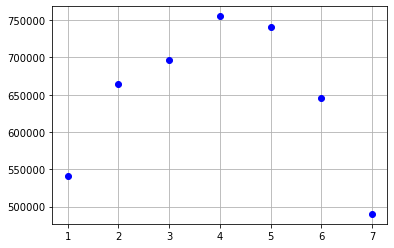

In [14]:
x = []
y = []

for row in dataPerDayOfWeekFetched:
    x.append(row.dayOfWeek)
    y.append(row["count"])

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x,y, 'bo')
plt.grid()
plt.show()